<a href="https://colab.research.google.com/github/chadmiral/heightmaps/blob/main/Heightmap_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heightmap Decomposition
Satellite data and DEM scans provide an excellent, high detail dataset from which to build digital terrain and biomes. We can easily retrieve the heightmap, but often artists stop there, unsure what else to do besides displace the height of a grid. Let's dive a bit deeper and see what additional data channels we might be able to extract from the humble heightmap.


In [ ]:
#!apt-get install blender
#!pip install pysheds

In [ ]:
import numpy as np
import scipy
import math
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
eps = 1e-10

#Download a Heightmap of Mt Saint Helens
I've been fascinated with this mountain ever since it blew its top when I was in elementary school. It is a favorite destination of mine for spring ski touring. Even better, it has really interesting topography, complete with a crater, lava flows and plenty of hydraulic erosion features

In [ ]:
# grab a heightmap off my gdrive
#from google.colab import drive
#drive.mount('/content/drive')
#heightmapPath = '/content/drive/MyDrive/Heightmaps/Mt Saint Helens terrain/Mt Saint Helens Height Map (Merged).png'

In [ ]:
# download heightmap from my public github (so this notebook will work anywhere)
!curl https://raw.githubusercontent.com/chadmiral/heightmaps/main/Mt%20Saint%20Helens%20Height%20Map%20\(Merged\).png > heightmap.png
heightmapPath = "/content/heightmap.png"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1554k  100 1554k    0     0  1130k      0  0:00:01  0:00:01 --:--:-- 1131k


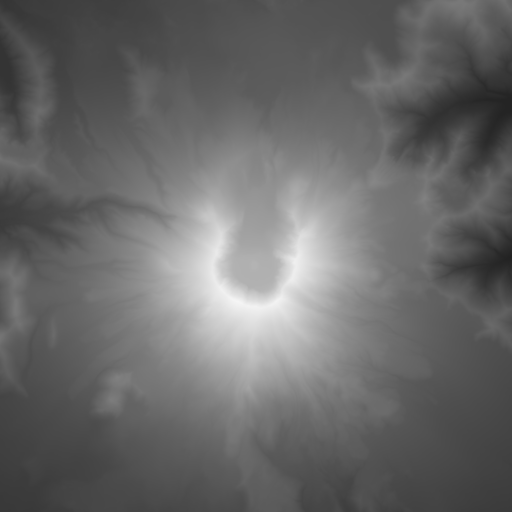

In [ ]:
#TODO - grab DEM from USGS directly. The ones on my drive are from TerrainParty, so geared towards City Skyline (heights are compressed, etc...)
with Image.open(heightmapPath) as hm32:
  hm32 = hm32.resize((1024,1024))
  hm32 = hm32.crop((256,256,256+512,256+512))
  hm32 = hm32.resize((512,512))
  display(hm32)

#Define some utility functions we'll use later...

In [ ]:
def normalize(i):
  return (i - i.min()) / (i.max() - i.min())

In [ ]:
def displayImage(i, norm=True):
  i_norm = i
  if(norm):
    i_norm = normalize(i)
  display(Image.fromarray(np.uint8(i_norm * 255), mode='L'))

# The Partial Derivates of the Heightfield
We're going to derive some auxilliary textures from the heightmap that we can use as masks for foliage / decorator density.

The first partial derivatives, dh/dx and dh/dy describe the slope of the heightfield in the x and y directions, respectively. From this we can derive maps such as slope steepness and slope aspect.

The second partial derivates represent the curvature of the surface. From these we can derive maps which isolate ridges and valleys, and inform where water flows, sediment accumulates, etc.

We derive the first and second derivatives using a convolution of the heightmap with a 3x3 moving window / kernel. The kernel width determines the scale of the details which will be picked up in the maps we derive.

In [ ]:
# use finite differences method to find dh/dx and dh/dy (Evans/Young method)
np_height = np.array(hm32)
#np_height = scipy.ndimage.gaussian_filter(np_height, 1.5) # filter out high-freq noise

w = 1e8 / np_height.shape[0] #pixel width (should probably be in meters, but I'll fudge it for now)



#partial first and second derivatives of elevation map
p = scipy.ndimage.convolve(np_height, [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]) / (6*w)    # dh/dx
q = scipy.ndimage.convolve(np_height, [[ 1, 1, 1], [ 0, 0, 0], [-1,-1,-1]]) / (6*w)    # dh/dy





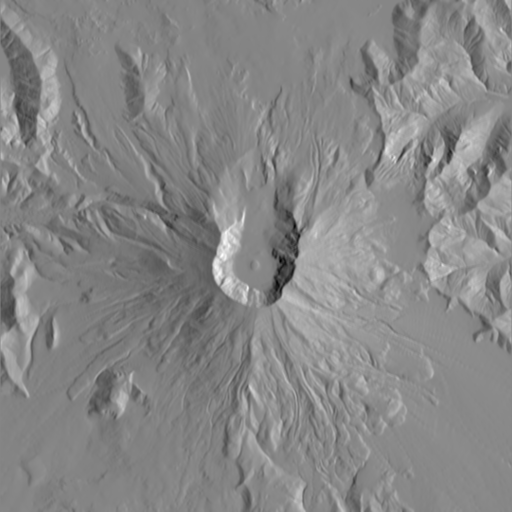

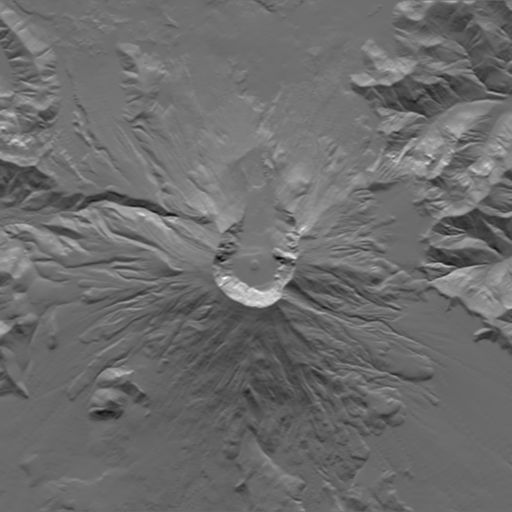

In [ ]:
#display normalized images of r,t,s,p,q
displayImage(p)
displayImage(q)



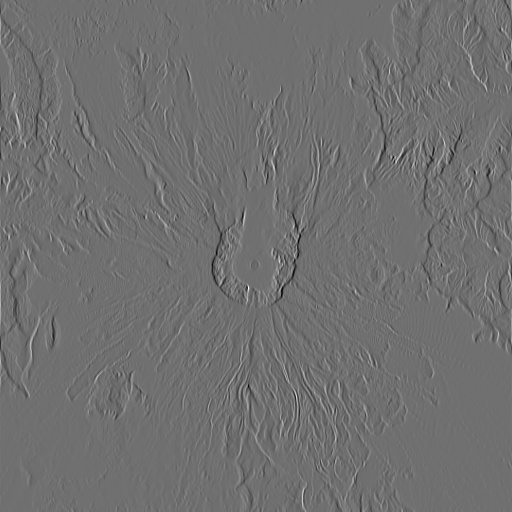

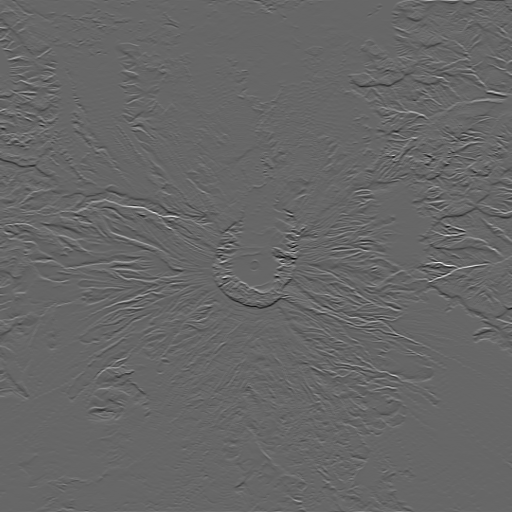

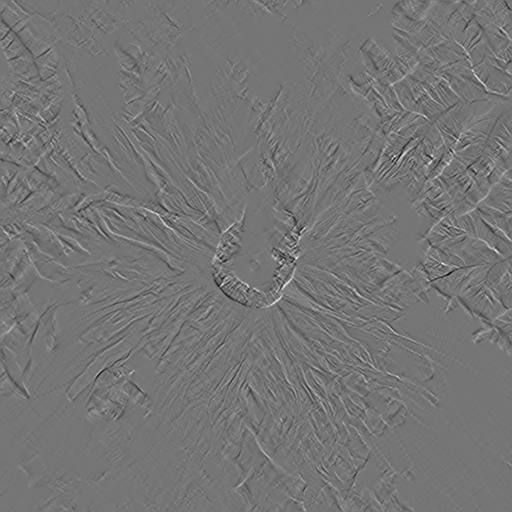

In [ ]:
#partial second derivatives
r = scipy.ndimage.convolve(np_height, [[ 1,-2, 1], [ 1,-2, 1], [ 1,-2, 1]]) / (3*w*w)  # d2h/dx2
t = scipy.ndimage.convolve(np_height, [[ 1, 1, 1], [-2,-2,-2], [ 1, 1, 1]]) / (3*w*w)  # d2h/dy2
s = scipy.ndimage.convolve(np_height, [[-1, 0, 1], [ 0, 0, 0], [ 1, 0,-1]]) / (4*w*w)  # d2h/dxdy

displayImage(r)
displayImage(t)
displayImage(s)

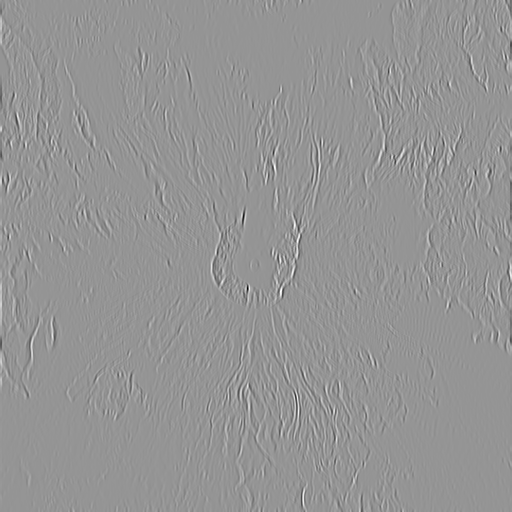

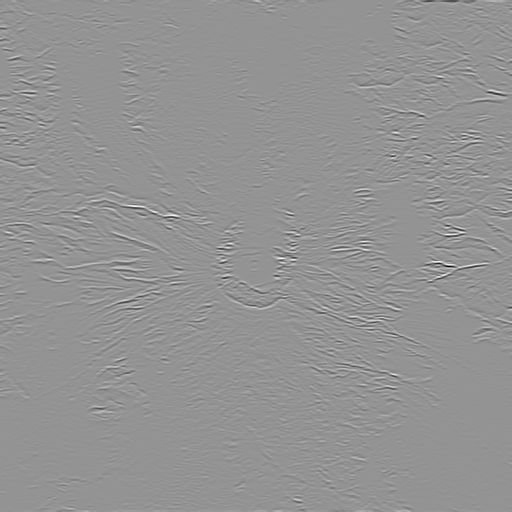

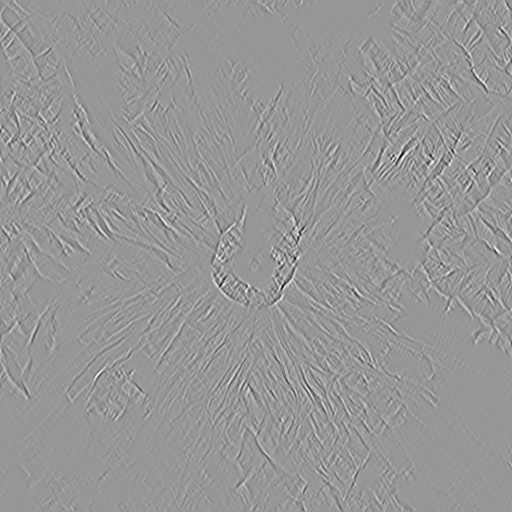

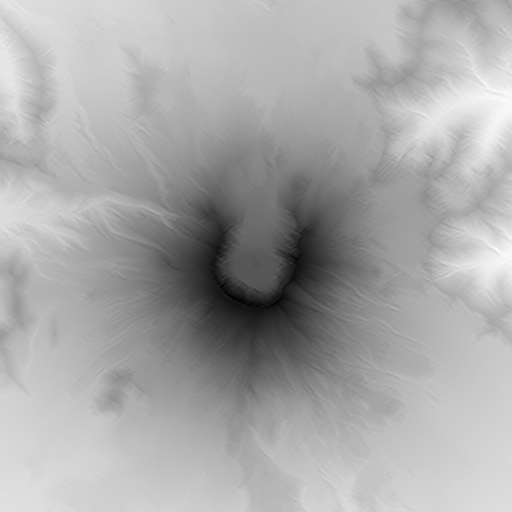

In [ ]:
# using Florinsky method, with a 5x5 convolution kernel, we can get the 3rd partial derivatives as well
g = scipy.ndimage.convolve(np_height, [[-1, 2, 0, -2, 1],
                                       [-1, 2, 0, -2, 1],
                                       [-1, 2, 0, -2, 1],
                                       [-1, 2, 0, -2, 1],
                                       [-1, 2, 0, -2, 1]]) / (10*w*w*w) # d3h/dx3

h = scipy.ndimage.convolve(np_height, [[ 1,  1,  1,  1,  1],
                                       [-2, -2, -2, -2, -2],
                                       [ 0,  0,  0,  0,  0],
                                       [ 2,  2,  2,  2,  2],
                                       [-1, -1, -1, -1, -1]]) / (10*w*w*w) # d3h/dy3

k = scipy.ndimage.convolve(np_height, [[ 4, -2, -4, -2,  4],
                                       [ 2, -1, -2, -1,  2],
                                       [ 0,  0,  0,  0,  0],
                                       [-2,  1,  2,  1, -2],
                                       [-4,  2,  4,  2, -4]]) / (70*w*w*w) # d3z/dx2dy

m = scipy.ndimage.convolve(np_height, [[-4, -2,  0, -2,  4],
                                       [ 2,  1,  0, -1, -2],
                                       [ 4,  2,  0, -2, -4],
                                       [ 2,  1,  0, -1, -2],
                                       [-4, -2,  0,  2,  4]]) / (70*w*w*w) #dz3/dxdy2

displayImage(g)
displayImage(h)
displayImage(k)
displayImage(m)

# Channel Packed First Partial Derivatives (Slope)
If we channel pack dh/dx and dh/dy into the red and green channels, we get something that should look very familiar to all 3D artists - it almost looks like a normal map (although, it's not, it's the gradient vector)

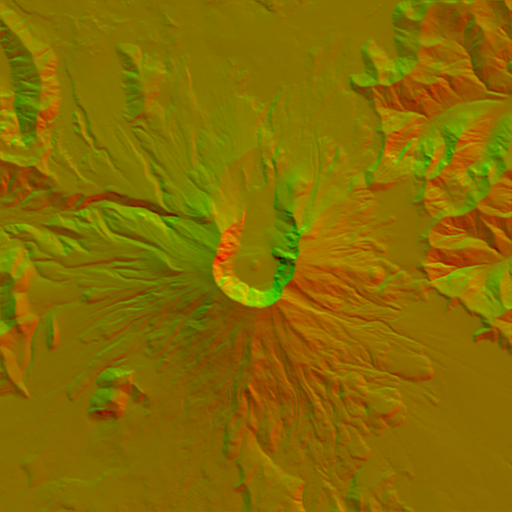

In [ ]:
#display dhdx_dhdy as a channel packed image
fill = np.zeros([np_height.shape[0], np_height.shape[1]], dtype=np.float32)

h_norm = normalize(np_height)

#note, we are downsampling here from 32bpp to 8bpp, so possible data loss / stair stepping artifacts if we use the merged image
red = Image.fromarray(np.uint8(normalize(p) * 255), mode='L')
green = Image.fromarray(np.uint8(normalize(q) * 255), mode='L')
blue = Image.fromarray(np.uint8(fill * 255), mode='L')

dhdx_dhdy = Image.merge('RGB', (red, green, blue))
display(dhdx_dhdy)

# The Slope Gradient
We can also combine dh/dx and dh/dy in a different way, to generate the slope gradient (really, the magnitude of the gradient vector). This represents the "steepness" of the heightfield. We can use this to mask off areas where it may be too steep for trees to grow, or boulders to settle

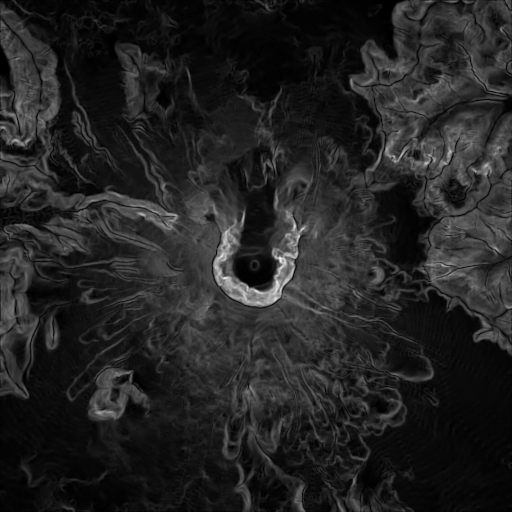

In [ ]:
# Slope Gradient
G = np.arctan(np.sqrt(p*p + q*q))
displayImage(G)

We can also channel pack the 3 partial second derivatives, and get the result below, but it's a little unclear what that represents.

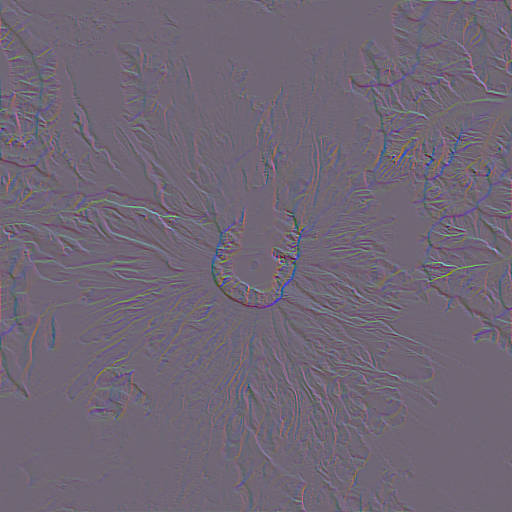

In [ ]:
red = Image.fromarray(np.uint8(normalize(r) * 255), mode='L')
green = Image.fromarray(np.uint8(normalize(t) * 255), mode='L')
blue = Image.fromarray(np.uint8(normalize(s) * 255), mode='L')

rts = Image.merge('RGB', (red, green, blue))
display(rts)

# Curvature Maps
With some more math we can make better sense of the second partial derivatives. We'll separate the curvature first into "horizontal curvature" and vertical curvature.

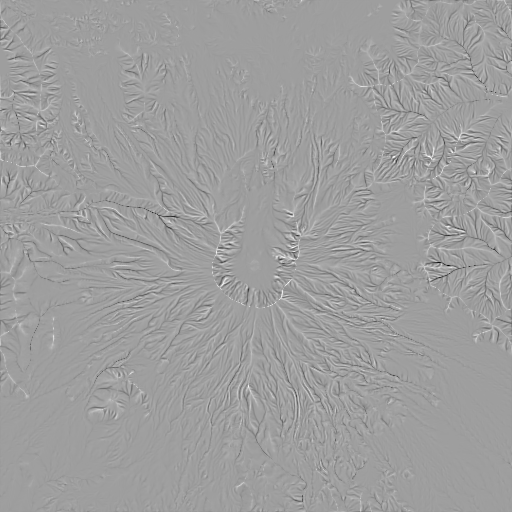

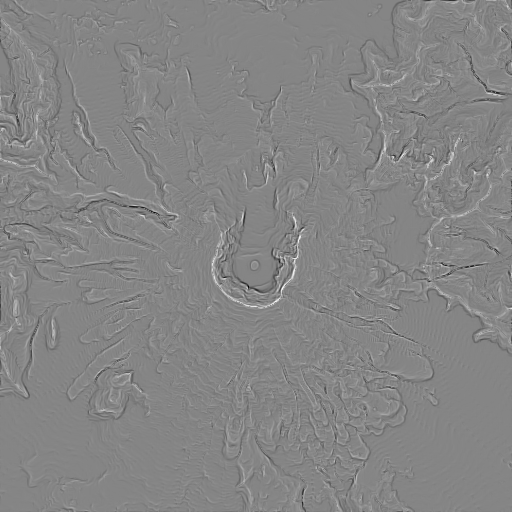

In [ ]:
# horizontal curvature (Digital Terrain Analysis in Soil Science and Geology - Igor Florinsky)
numerator = -(q*q*r - 2*p*q*s + p*p*t)
denominator = (p*p + q*q) * np.sqrt(1 + p*p + q*q)
K_h = numerator / np.where(np.abs(denominator) < eps, eps, denominator)

#vertical curvature
numerator = -(p*p*r + 2*p*q*s + q*q*t)
denominator = (p*p + q*q) * np.sqrt(np.power((1 + p*p + q*q), 3))
K_v = numerator / np.where(np.abs(denominator) < eps, eps, denominator)

displayImage(K_h)
displayImage(K_v)

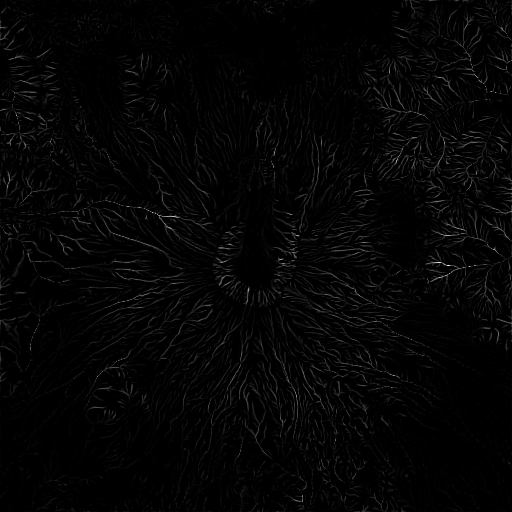

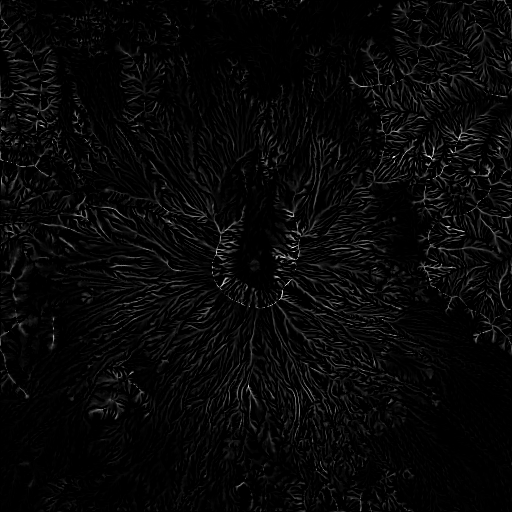

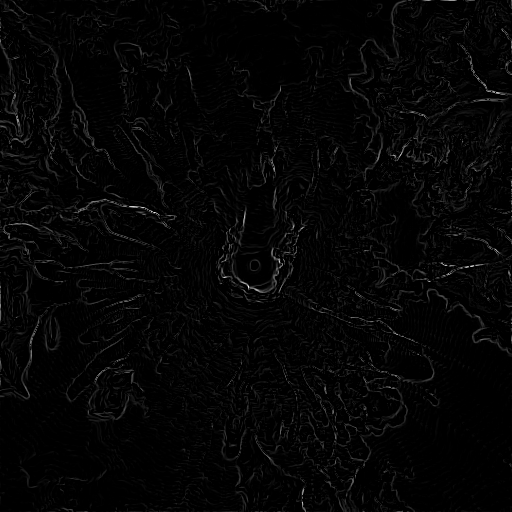

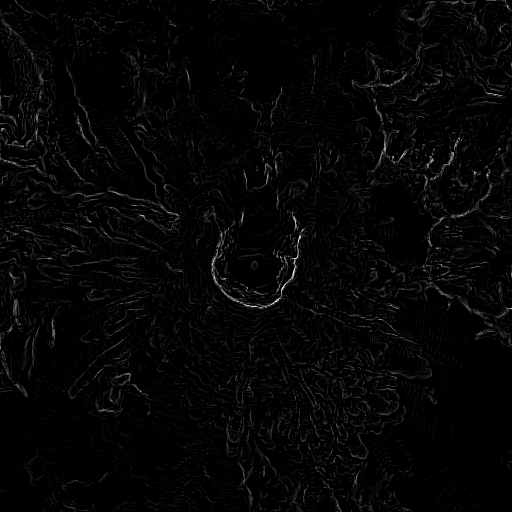

In [ ]:
# separate further into ridge and valley masks for both horizontal and vertical curvature
K_h_neg = np.where(K_h <= 0, -K_h, 0)
K_h_pos = np.where(K_h >= 0, K_h, 0)
K_v_neg = np.where(K_v <= 0, -K_v, 0)
K_v_pos = np.where(K_v >= 0, K_v, 0)

displayImage(K_h_neg)
displayImage(K_h_pos)

displayImage(K_v_neg)
displayImage(K_v_pos)

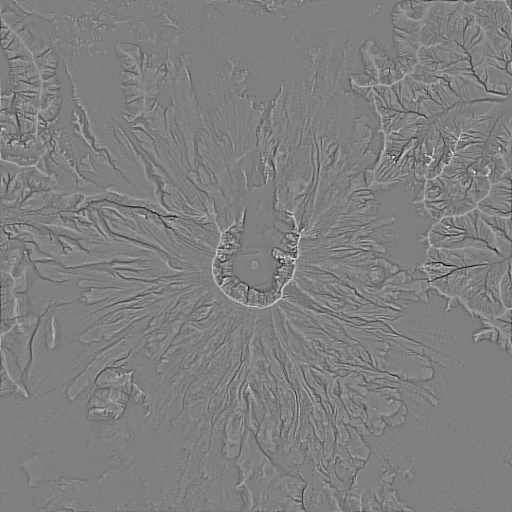

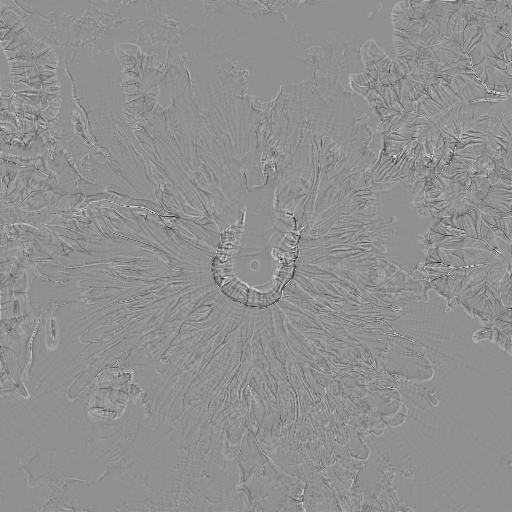

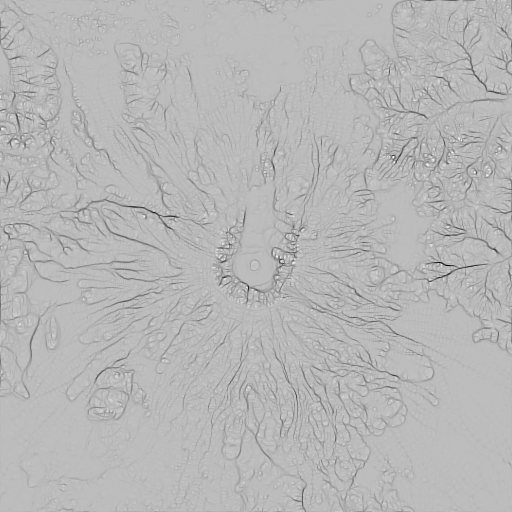

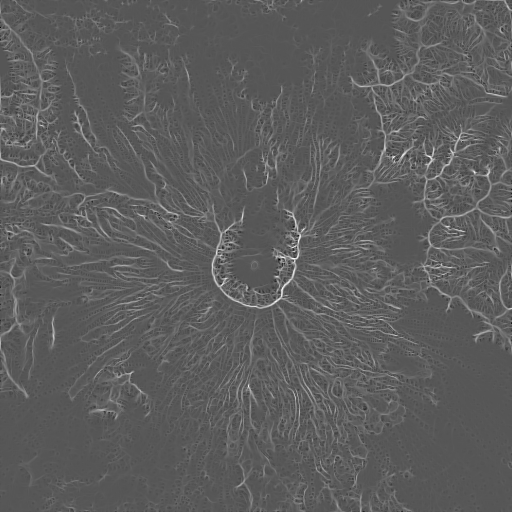

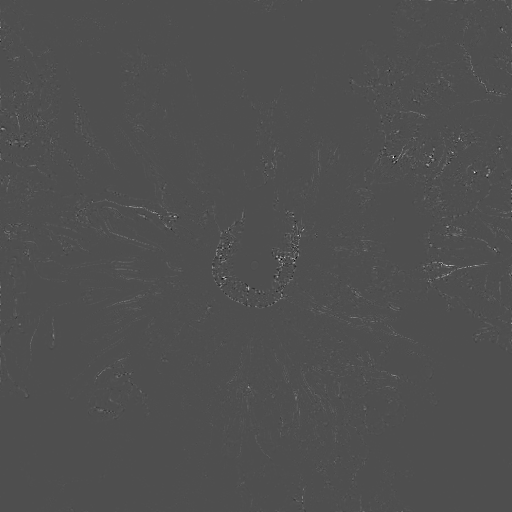

In [ ]:
H = 0.5 * (K_h + K_v) # Mean Curvature
E = 0.5 * (K_h - K_v) # Difference Curvature

numerator = (r*t - s*s)
denominator = (1 + p*p + q*q)
denominator = denominator * denominator
K = numerator / np.where(np.abs(denominator) < eps, eps, denominator) # Gaussian Curvature

K_a = K_v * K_h # Accumulation Curvature

radicand = H*H - K
M = np.sqrt(np.where(radicand >= 0, radicand, 0)) # Unsphericity Curvature

k_min = H - M # Minimal Curvature
k_max = H + M # Maximal Curvature

displayImage(H)
displayImage(E)
displayImage(k_min)
displayImage(k_max)
displayImage(K_a)

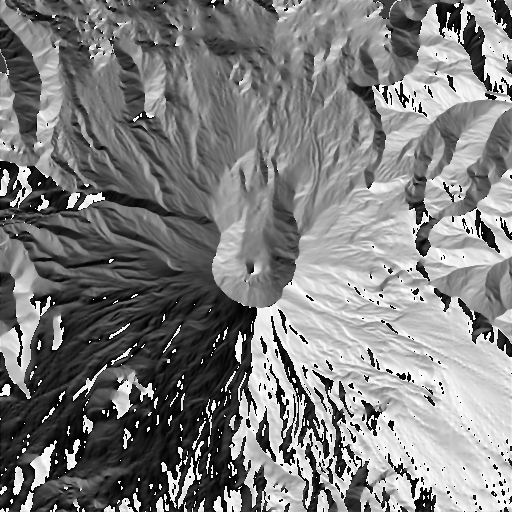

In [ ]:
# Slope Aspect
sp = np.where(p == 0, 0, np.where(p > 0, 1, -1))
sq = np.where(q == 0, 0, np.where(q > 0, 1, -1))

denominator = np.sqrt(p*p + q*q)
a = -q / np.where(np.abs(denominator) > eps, denominator, eps)
A = -90 * (1 - sq) * (1 - np.abs(sp)) + 180 * (1 + sp) - (180 / math.pi) * sp * np.arccos(a)

displayImage(A)

66.77689436401532
67.45884497418706


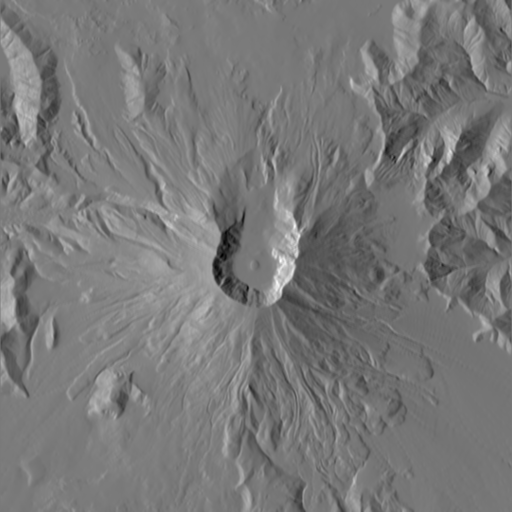

In [ ]:
# Solar Insolation (sun exposure)

#solar angles
theta = 90
psi = 20

#convert to radians
theta *= math.pi/180
psi *= math.pi/180

denominator = np.sqrt(1 + p*p + q*q)
a = math.sin(psi) - math.cos(psi) * (p * math.sin(theta) + q * math.cos(theta))
sa = np.where(a == 0, 0, np.where(a < 0, -1, 1))
I = (50 * (1 + sa * a)) / denominator

print(I.min())
print(I.max())

displayImage(I)

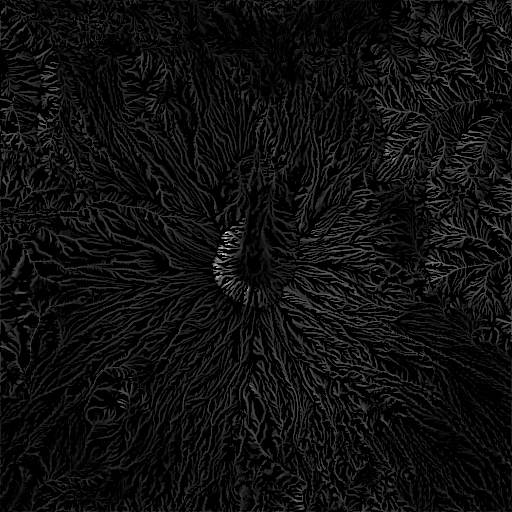

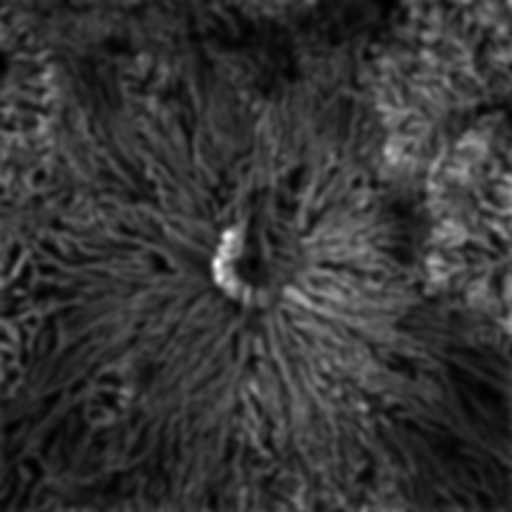

In [ ]:
# Soil Moisture
denominator = 1e-7 * G + 1e-8 * np.power(I - I.min(), 1)
S_moist = np.log(1 + 1e10 * K_h_neg) / np.where(np.abs(denominator) > eps, denominator, eps)
S_moist_filtered = scipy.ndimage.gaussian_filter(S_moist, 3)
displayImage(S_moist)
displayImage(S_moist_filtered)

# Temperature
We might be interested in the average temperature of our landscape so that we can place snow and ice, perhaps influence our biome composition, or modulate our materials. Temperature decreases with elevation, and increases with sun exposure. We can also incorporate evaporative cooling from our soil moisture and hydrology maps

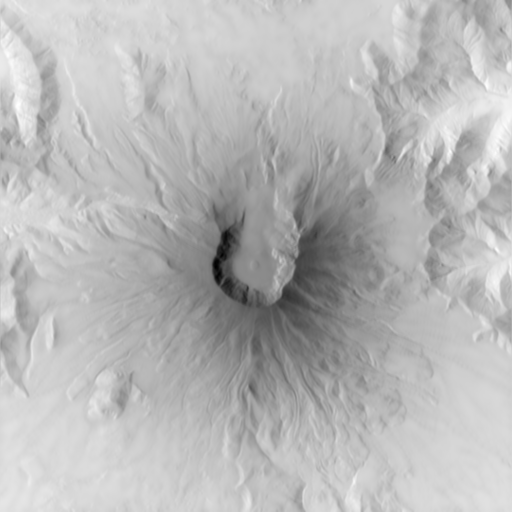

In [ ]:
# Temperature
Hn = normalize(np_height)
T = normalize(I) + (1 - Hn) - 0.4 * normalize(S_moist_filtered)
displayImage(T)

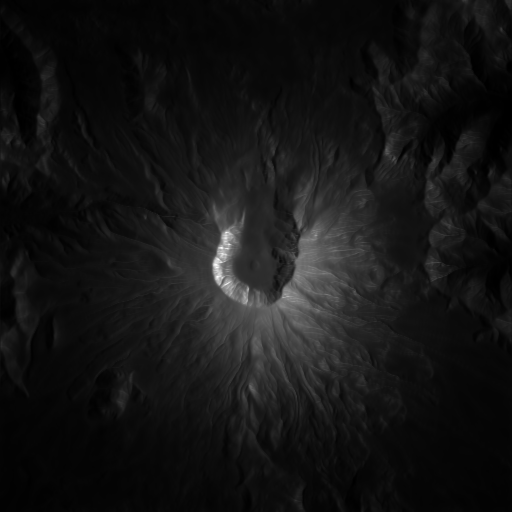

In [ ]:
# Snow Mask
T_inv = np.power(normalize(1 - T), 2)
Snow = T_inv * (1 + normalize(K_h_neg))
displayImage(Snow)

# Hydrology
Next, let's see if we can gather some information about the river network based on the topography. First, we will find the "D8" flow directions for each. This tells us which direction water will flow out of a cell.

128
-1


Text(0.5, 1.0, 'Flow direction grid')

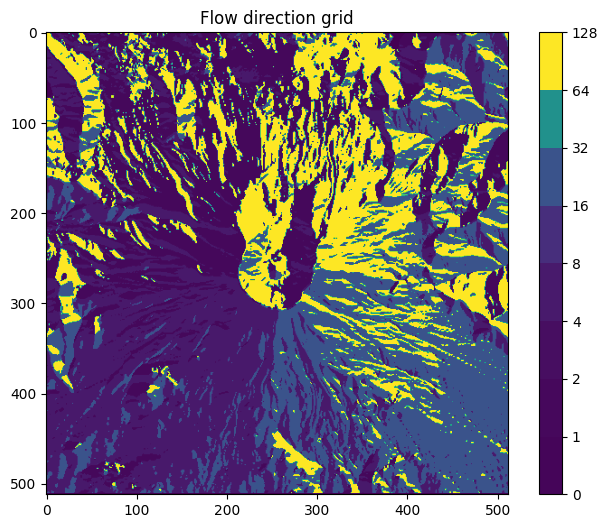

In [ ]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

def calculate_d8_flow_direction(dem):
    rows, cols = dem.shape
    flow_direction = np.zeros_like(dem, dtype=int) - 1

    for row in range(1, rows - 1):
        for col in range(1, cols - 1):
            center_elevation = dem[row, col]
            neighbors = [
                dem[row, col - 1], dem[row + 1, col - 1],
                dem[row + 1, col], dem[row + 1, col + 1],
                dem[row, col + 1], dem[row - 1, col + 1],
                dem[row - 1, col], dem[row - 1, col - 1]
                #dem[row - 1, col - 1], dem[row - 1, col], dem[row - 1, col + 1],
                #dem[row, col - 1], dem[row, col + 1],
                #dem[row + 1, col - 1], dem[row + 1, col], dem[row + 1, col + 1]
            ]

            # Find the steepest descent neighbor
            max_slope = 0
            flow_dir = -1
            for i in range(8):
                if neighbors[i] > center_elevation:
                    d = 1
                    if (i%2 == 0):
                      d = 1.414
                    slope = (neighbors[i] - center_elevation) / d  # 1 for diagonal, 2 for cardinal
                    if slope > max_slope:
                        max_slope = slope
                        flow_dir = i

            flow_direction[row, col] = dirmap[flow_dir]
            if flow_dir < 0:
              flow_direction[row, col] = -1


    return flow_direction

flow_dir = calculate_d8_flow_direction(np_height)
print(flow_dir.max())
print(flow_dir.min())

# Plot the flow direction grid
fig = plt.figure(figsize=(8,6))
plt.imshow(flow_dir,  cmap='viridis', zorder=1)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.title('Flow direction grid')

# Flow Accumulation
From the direction map, we can now calculate flow accumulation, which is the measure of how much water flows into each pixel from the surrounding area. This is the first thing we'll need to calculate iteratively - so we're taking a very small step towards "simulation".
Flow accumulation will give us additional insight into the soil moisture of the area, and reveal the river network

In [ ]:


def count_neighbor_flow(i, j, flow_dir):
  flow_count = 0
  upstream_cells = []
  if flow_dir[i - 1, j] == 1:
    upstream_cells.append((i - 1, j))
    flow_count += 1
  if flow_dir[i - 1, j - 1] == 2:
    upstream_cells.append((i - 1, j - 1))
    flow_count += 1
  if flow_dir[i, j - 1] == 4:
    upstream_cells.append((i, j - 1))
    flow_count += 1
  if flow_dir[i + 1, j - 1] == 8:
    upstream_cells.append((i + 1, j - 1))
    flow_count += 1
  if flow_dir[i + 1, j] == 16:
    upstream_cells.append((i + 1, j))
    flow_count += 1
  if flow_dir[i + 1, j + 1] == 32:
    upstream_cells.append((i + 1, j + 1))
    flow_count += 1
  if flow_dir[i, j + 1] == 64:
    upstream_cells.append((i, j + 1))
    flow_count += 1
  if flow_dir[i - 1, j + 1] == 128:
    upstream_cells.append((i - 1, j + 1))
    flow_count += 1
  return flow_count, upstream_cells

'''
def get_downstream_cell(row, col, flow_dir):
    # Calculate the coordinates of the downstream cell based on flow direction
    if flow_dir == 64:
        return row, col - 1
    elif flow_dir == 128:
        return row + 1, col - 1
    elif flow_dir == 1:
        return row + 1, col
    elif flow_dir == 2:
        return row + 1, col + 1
    elif flow_dir == 4:
        return row, col + 1
    elif flow_dir == 8:
        return row - 1, col + 1
    elif flow_dir == 16:
        return row - 1, col
    elif flow_dir == 32:
        return row - 1, col - 1
    else:
        return row, col  # No flow direction (-1)

def calculate_flow_accumulation_at_cell(flow_direction, i, j):
  visited = np.zeros_like(dem, dtype=bool)
  stack = [(i,j)]

  neighbor_flow = [
                flow_direction[row - 1, col - 1],
                flow_direction[row - 1, col],
                flow_direction[row - 1, col + 1],
                flow_direction[row, col - 1],
                center_elevation,
                flow_direction[row, col + 1],
                flow_direction[row + 1, col - 1],
                flow_direction[row + 1, col],
                flow_direction[row + 1, col + 1]
              ]

  while stack:
    row, col = stack.pop()



def calculate_flow_accumulation(dem, flow_direction):
    rows, cols = dem.shape
    flow_accumulation = np.zeros_like(dem, dtype=np.uint32)
    stack = []
    visited = np.zeros_like(dem, dtype=bool)

    for row in range(rows):
        for col in range(cols):
            if flow_direction[row, col] != -1:
                stack.append((row, col))

    while stack:
        row, col = stack.pop()
        if not visited[row, col]:
            downstream_row, downstream_col = get_downstream_cell(row, col, flow_direction[row, col])
            if 0 <= downstream_row < rows and 0 <= downstream_col < cols:
                flow_accumulation[downstream_row, downstream_col] += flow_accumulation[row, col] + 1
                stack.append((downstream_row, downstream_col))
                visited[row, col] = True

    return flow_accumulation
    '''
def calculate_flow_accumulation_at_cell(i, j, flow_direction):
  stack = []
  cell_flow = 0
  visited = np.zeros_like(flow_direction, dtype=bool)

  if(flow_direction[i, j] != -1):
    stack.append((i, j))

  while stack:
    row, col = stack.pop()
    if not visited[row, col]:
      f, upstream_cells = count_neighbor_flow(row, col, flow_direction)
      cell_flow += f
      for c in upstream_cells:
        stack.append(c)
      visited[row, col] = True

  return cell_flow


def calculate_flow_accumulation(flow_direction):
  flow_accum = np.zeros_like(flow_direction, dtype=np.uint32)
  rows, cols = flow_direction.shape

  for i in range(1, rows - 1):
    for j in range(1, cols - 1):
      #flow_accum[i, j] = count_neighbor_flow(i, j, flow_direction)
      flow_accum[i, j] = calculate_flow_accumulation_at_cell(i, j, flow_direction)

  return flow_accum


Fa = calculate_flow_accumulation(flow_dir)
#print(Fa.min())
#print(Fa.max())

#displayImage(flow_dir / 8, False)
Fa_log = np.log(1 + normalize(Fa))
displayImage(Fa_log)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(Fa, zorder=2,
               cmap='cubehelix',
               #norm=colors.LogNorm(1, Fa.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.tight_layout()


NameError: ignored